<a href="https://colab.research.google.com/github/hida0/ESAA/blob/HW/Week10_HW1_%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 개념 정리 & 필사
(파이썬 머신러닝 완벽 가이드 ch4. 2  pg. 201~211)

### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- 해당 데이터는 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러 가지 피처를 수집한 데이터이다. 
- 수집된 피처 세트를 기반으로 결정 트리를 이용하여 어떤 동작인디 예측한다.
- train은 학습 용도의 피처 데이터 세트와 레이블 데이터 세트, test에는 테스트용 피처 데이터 세트와 클래스값 데이터 세트가 들어있다.
- DataFrame으로 로딩하여 피처의 명칭을 간단히 확인한다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# feature.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있으며 이를 DataFrame으로 로드
feature_name_df = pd.read_csv("/content/drive/MyDrive/ESAA/data/features.txt", sep='\s+', header=None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고 피처명만 리스트 객체로 생성한 뒤 샘플로 10개 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print("전체 피처명에서 10개만 추출:\n", feature_name[:10])

전체 피처명에서 10개만 추출:
 ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- 피처명을 보면 인체의 움직임과 관련된 속성의 평균/표준편차가 X,Y,Z축 값으로 되어있음을 유추할 수 있다.
- 피처명을 가지고 있는 features_info.txt 파일은 중복된 피처명을 가지고 있다.
- 총 42개의 피처명이 중복되어 있으므로, 중복된 피처명에 대해서는 원본 피처명에 _1 또는 _2를 추가로 부여하여 변경한 뒤에 이를 이용하여 데이터를 DataFrame으로 로드한다.
- 이를 위해서 원본 피처명에 _1 또는 _2를 추가로 부여하여 새로운 피처명을 가지는 DataFrame을 반환하게 하는 새로운 유틸리티 함수를 생성한다.



In [ ]:
# 중복된 피처명이 얼마나 있는지 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- train의 학습용 피처 데이터 세트와 레이블 데이터 세트, test의 테스트용 피처 데이터 세트와 레이블 데이터 세트를 각각 학습용/테스트용 DataFrame에 로드한다.
- 앞에서 생성한 유틸리티 함수를 이용하여 DataFrame을 생성하는 로직을 또 다른 새로운 유틸리티 함수로 생성한다.

In [ ]:
# 사용자 행동 데이터셋에 DataFrame을 반환하는 함수
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/features.txt' ,sep='\s+', header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. Column 명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/ESAA/data/X_train.txt',sep='\s+', names = feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/ESAA/data/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/ESAA/data/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/ESAA/data/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [ ]:
# 학습용/테스트용 데이터 세트 로드하기
X_train, X_test, y_train, y_test = get_human_dataset()

# 로드한 학습용 피처 데이터 세트 살펴보기
print("## 학습 피처 데이터 세트 ##")
print(X_train.info())

## 학습 피처 데이터 세트 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [ ]:
y_train['action'].value_counts()
# 레이블 값은 1,2,3,4,5,6의 6개 값이고, 특정값으로 왜곡되지 않고 비교적 고르게 분포

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- 사이킷런의 **`DecisionTreeClassifier`**를 이용하여 동작 예측 분류를 수행한다.
- 먼저 `DecisionTreeClassifier`의 하이퍼 파라미터는 모두 디폴트 값으로 설정하여 수행하고, **`get_params()`** 메서드를 이용하여 이때의 **디폴트 하이퍼 파라미터 값을 모두 추출**한다.
- 약 85.48%의 정확도를 나타낸다.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("결정 트리 예측 정확도:{0:.4f}".format(accuracy))

결정 트리 예측 정확도:0.8548


In [ ]:
# DecisionTreeClassifier의 기본 하이퍼 파라미터 추출
print("DecisionTreeClassifier 기본 하이퍼 파라미터:\n", dt_clf.get_params())

DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- 다음으로 결정 트리의 트리 깊이가 예측 정확도에 주는 영향을 살펴본다.
- 결정 트리의 경우 분류를 위해 리프 노드(클래스 결정 노드)가 될 수 있는 적합한 수준이 될 때까지 지속해서 트리의 분할을 수행하면서 깊이가 깊어진다.
- **`GridSearchCV`**를 이용하여 사이킷런 결정 트리의 깊이를 조절하는 하이퍼 파라미터 **`max_depth`** 값을 변화시키며서 예측 성능을 확인한다.
- 5개의 교차 검증 세트에 대해 max_depth를 계속 늘리면서 예측 성능을 측정한다.
- **`best_score_`**를 이용하여 **최고 평균 정확도 수치**를, **`best_params_`**를 이용하여 **최적 하이퍼 파라미터**를 추출한다.
- 5개의 CV 세트에서 max_depth 값에 따라 예측 성능이 어떻게 변했는지 GridSearchCV 객체의 `cv_results` 속성을 통해 확인한다.
- **`cv_results`** 속성은 CV 세트에 하이퍼 파라미터를 순차적으로 입력했을 때의 성능 수치를 가지고 있다. 이를 이용하여 max_depth에 따른 평가 데이터 세트의 평균 정확도 수치(cv_results_의 'mean_test_score'값)를 추출한다.

In [ ]:
from sklearn.model_selection import GridSearchCV

params ={
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print("GridSearchCV 최고 평균 정확도 수치: {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV 최적 하이퍼 파라미터:", grid_cv.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [ ]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트와 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [ ]:
max_depths = [6,8,10,12,16,20,24]

# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능을 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print("max_depth = {0} 정확도: {1:.4f}".format(depth, accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- max_depth가 8인 경우 약 87.07%로 가장 높은 정확도를 나타내며, max_depth가 8을 넘어가면서 정확도가 계속 감소한다.
- 결정 트리는 깊이가 깊어질수록 과적합의 영향력이 커지므로 하이퍼 파라미터를 이용하여 깊이를 제어해야 한다.
- 복잡한 모델보다도 트리 깊이를 낮춘 단순한 모델이 더욱 효과적인 결과를 가져올 수 있다.
- 다음으로 **`max_depth`**와 **`min_samples_split`**을 같이 변경하면서 정확도 성능을 튜닝한다.

In [ ]:
parmas = {
    'max_depth' : [8,12,16,20],
    'min_samples_split' : [16,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print("GridSearchCV 최고 평균 정확도 수치: {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV 최적 하이퍼 파라미터:", grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


### 결정 트리 실습 - 사용자 행동 인식 데이터 세트
- GridSearchCV 객체의 속성인 **`best_estimator_`**는 앞서 구한 **최적 하이퍼 파라미터인 값들로 학습이 완료된 Estimator 객체**이다.
- 이를 이용하여 테스트 데이터 세트에 예측을 수행한다.
- **`feature_importances_`** 속성을 이용하여 결정 트리에서 **각 피처의 중요도**를 알아볼 수 있다.
- 막대 그래프상에서 확인해보면 이 중 가장 높은 중요도를 가진 Top 5의 피처들이 매우 중요하게 규칙 생성에 영향을 미치고 있는 것을 알 수 있다.

In [ ]:
best_dt_clf = grid_cv.best_estimator_
pred1 = best_dt_clf.predict(X_test)
accuracy1 = accuracy_score(y_test, pred1)
print("결정 트리 예측 정확도: {0:.4f}".format(accuracy1))

결정 트리 예측 정확도: 0.8575


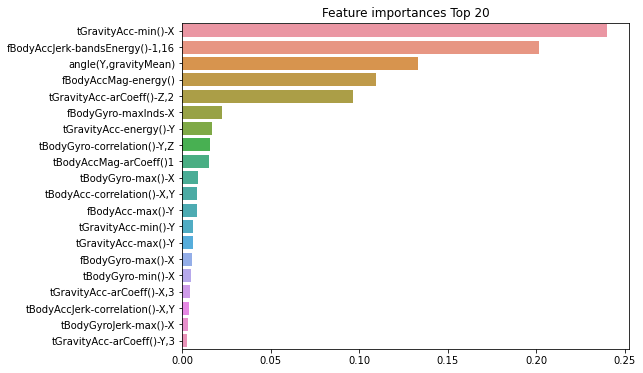

In [ ]:
import seaborn as sns

ftr_importances_values = best_dt_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, Seaborn의 막대그래프로 쉽게 표현하기 위해 Series로 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도 값으로 Series를 정렬하기 위해 내림차순으로 20위까지 선택
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("Feature importances Top 20")
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()